In [54]:
from cs592_proj.algorithms import TREX
from cs592_proj.datasets import CustomDataset
from cs592_proj.algorithms.run_config import RunConfig
import warnings
import jax
import jax.numpy as jnp
import numpy as np
from gymnax.visualize import Visualizer
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=FutureWarning)

dataset = CustomDataset.from_resource_path('custom_datasets/policy_params_4000768.npz', env_name="space_invaders") 

In [55]:
def make_fragments(traj, frag_len=25, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    T = len(traj["observations"]) - 1  # last obs has no action
    if T < frag_len: return []
    starts = rng.integers(0, T - frag_len + 1, size=max(1, T // frag_len))
    observations = np.array(traj["observations"])
    rewards = np.array(traj["reward"])
    return [(observations[s:s+frag_len], rewards) for s in starts]

def make_ranked_pairs(trajs, n_pairs=20000, frag_len=90, rng=None, tie_margin=0.0):
    rng = np.random.default_rng() if rng is None else rng
    # flatten all fragments
    frags = []
    for tr in trajs:
        frags += make_fragments(tr, frag_len, rng)
    frags = [(o.astype(np.float32), r.astype(np.float32)) for o,r in frags]
    # sample pairs + label by true return
    pairs = []
    for _ in range(min(n_pairs, len(frags)**2)):
        i, j = rng.integers(0, len(frags), size=2)
        (o1, r1), (o2, r2) = frags[i], frags[j]
        g1, g2 = float(r1.sum()), float(r2.sum())
        if abs(g1-g2) <= tie_margin: continue
        y = 1.0 if g1 > g2 else 0.0
        pairs.append((o1, o2, y))
    return pairs


In [56]:
pairs = make_ranked_pairs(dataset)
print(len(pairs))

19042


In [57]:
print(dataset.dataset_impl["reward"].shape)

(100, 1000)


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.,
        0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 0., 0., 2.,
        0., 1., 0., 0., 0., 6., 0., 0., 4., 0., 2., 0., 0., 0., 6., 0., 0.,
        4., 0., 4., 0., 6., 0., 0., 7., 0., 7., 0., 9., 0., 1., 0., 0., 5.,
        0., 6., 0., 4., 0., 3., 0., 0., 1., 0., 5., 0., 0., 0., 1.]),
 array([134.        , 134.44000244, 134.88000488, 135.32000732,
        135.75999451, 136.19999695, 136.63999939, 137.08000183,
        137.52000427, 137.96000671, 138.3999939 , 138.83999634,
        139.27999878, 139.72000122, 140.16000366, 140.6000061 ,
        141.03999329, 141.47999573, 141.91999817, 142.36000061,
        142.80000305, 143.24000549, 143.67999268, 144.11999512,
        144.55999756, 145.        , 145.44000244, 145.88000488,
        146.32000732, 146.75999451, 147.19999695, 147.63999939,
        148.08000183, 148.52000427, 14

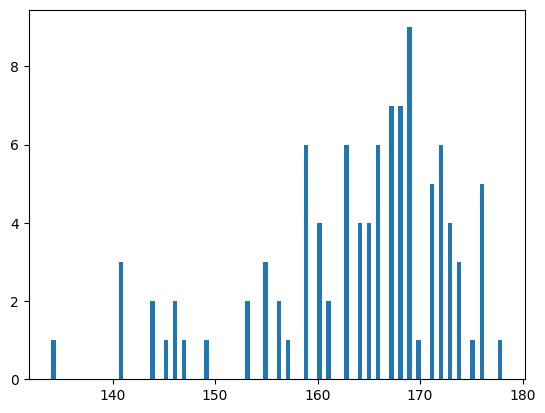

In [58]:
rewards = []
i=0
for d in dataset:
    i+=1
    rewards.append(sum(d["reward"]))

plt.hist(rewards, bins=100)




In [47]:

import pathlib
import re
dataset_paths = sorted(pathlib.Path("../custom_datasets").glob("*.npz"))
print(dataset_paths)
dataset_reward = []
iterations = []
for p in dataset_paths:
    number_regex = re.compile(r".*?_(\d+)\.npz$")
    match = number_regex.match(pathlib.Path(p).name)
    
    if match:
        strength = int(match.group(1))

        print(strength)

        rewards = [] 
        c = CustomDataset.from_resource_path(f'custom_datasets/{p.name}', env_name='space_invaders')
        for d in c:
            rewards.append(sum(d["reward"]))
        dataset_reward.append(np.mean(np.array(rewards)))
        iterations.append(strength)

[PosixPath('../custom_datasets/policy_params.npz'), PosixPath('../custom_datasets/policy_params_0.npz'), PosixPath('../custom_datasets/policy_params_1000192.npz'), PosixPath('../custom_datasets/policy_params_10001920.npz'), PosixPath('../custom_datasets/policy_params_11002112.npz'), PosixPath('../custom_datasets/policy_params_12002304.npz'), PosixPath('../custom_datasets/policy_params_13002496.npz'), PosixPath('../custom_datasets/policy_params_14002688.npz'), PosixPath('../custom_datasets/policy_params_15002880.npz'), PosixPath('../custom_datasets/policy_params_2000384.npz'), PosixPath('../custom_datasets/policy_params_3000576.npz'), PosixPath('../custom_datasets/policy_params_4000768.npz'), PosixPath('../custom_datasets/policy_params_5000960.npz'), PosixPath('../custom_datasets/policy_params_6001152.npz'), PosixPath('../custom_datasets/policy_params_7001344.npz'), PosixPath('../custom_datasets/policy_params_8001536.npz'), PosixPath('../custom_datasets/policy_params_9001728.npz')]
0
10

Text(0.5, 0, 'Iterations in Policy')

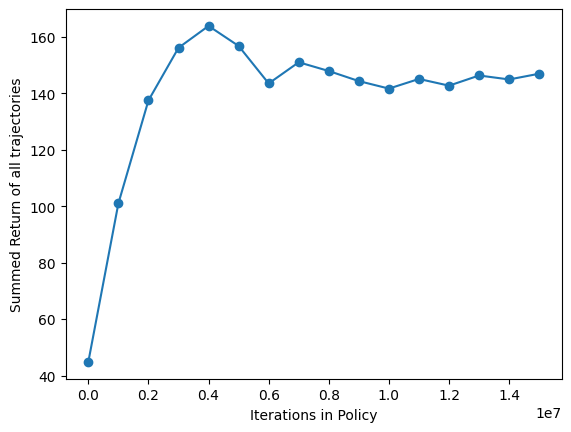

In [48]:
iterations = np.array(iterations)
dataset_reward = np.array(dataset_reward)
order = np.argsort(iterations)   # permutation that sorts x
iterations = iterations[order]
dataset_reward = dataset_reward[order]

plt.plot(iterations, dataset_reward, 'o-')
plt.ylabel('Summed Return of all trajectories')
plt.xlabel('Iterations in Policy')

In [40]:
trex = TREX()

trex.num_epochs = 1

run_config = RunConfig(
    num_timesteps=10000,
    num_evals=4,
    seed=1,
)


def progress_fn(step, metric, **kwargs):
    print(f"Progress {step}")

make_policy, params, metrics =trex.train_fn(
    run_config=run_config, 
    dataset=dataset, 
    progress_fn=progress_fn
)

{'action': Array([3, 0, 0, 0, 1, 2, 3, 2, 1, 0, 0, 3, 2, 1, 1, 3, 3, 3, 0, 1, 0, 3,
       2, 3, 3, 3, 3, 0, 0, 1, 1, 3, 1, 0, 2, 2, 1, 3, 0, 0, 0, 3, 3, 3,
       2, 1, 0, 3, 2, 1, 3, 3, 3, 3, 2, 1, 3, 3, 1, 2, 3, 2, 3, 0, 3, 0,
       3, 3, 2, 0, 0, 3, 3, 3, 1, 3, 3, 0, 3, 2, 3, 1, 2, 3, 3, 1, 2, 2,
       2, 3, 3, 2, 1, 3, 3, 1, 2, 0, 3, 0], dtype=int32), 'discount': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],      dtype=float32), 'next_observations': Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

{'epoch': 1, 'num_epochs': 1, 'train_loss': 0.5299961794825161, 'val_loss': 0.463860890893049}
start_learning


Progress 0
Progress 768
Progress 1536
Progress 2304
Progress 3072
Progress 3840
Progress 4608
Progress 5376
Progress 6144
Progress 6912
Progress 7680
Progress 8448
Progress 9216
Progress 9984
Progress 10752
Progress 11520


In [193]:

def visualize(env, policy, path):
    env = env.wrap_for_visualization()

    # visualize policy (TODO: abstract)
    state_seq, reward_seq = [], []
    key = jax.random.PRNGKey(1)
    key, key_reset = jax.random.split(key)
    state = env.reset(key_reset)
    i = 0
    while i < 300:
        state_seq.append(state.state_impl)
        key, key_act, key_step = jax.random.split(key, 3)
        obs = jnp.expand_dims(state.obs, 0)        
        action, _ = policy(obs, key_act)
        state = env.step(key_step, state, action.squeeze())
        reward_seq.append(state.reward)
        if state.done:
            break
        i += 1

    cum_rewards = jnp.cumsum(jnp.array(reward_seq))
    vis = Visualizer(env.env_impl, env.env_params, state_seq, cum_rewards)
    vis.animate(path)

    return cum_rewards[-1], np.sum(cum_rewards)

(Array(1., dtype=float32), Array(12., dtype=float32))

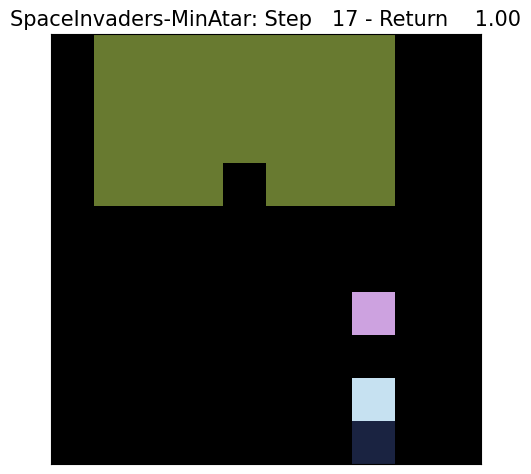

In [183]:

env = dataset.env
policy = make_policy(params, deterministic=True)

from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d_%H:%M:%S.gif")

out_path =  f"./test_gifs/{current_datetime}"
visualize(env, policy, out_path)


In [185]:

#TODO: add collatefn to add padding (or do it ealier)

from torch.utils.data import Dataset, DataLoader, random_split
import torch

def collate_pad(batch):
    # pad sequences to same T (left pad=False → right pad with zeros)
    o1s, o2s, ys = zip(*batch)
    T1 = max(x.shape[0] for x in o1s); T2 = max(x.shape[0] for x in o2s)
    def pad(stack, T):
        D = stack[0].shape[1]
        out = torch.zeros(len(stack), T, D)
        for i,x in enumerate(stack):
            out[i,:x.shape[0]] = x
        return out
    return pad(o1s, T1), pad(o2s, T2), torch.stack(ys)

class PrefPairsDS(Dataset):
    def __init__(self, pairs): self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        o1, o2, y = self.pairs[i]               # (T, obs_dim), (T, obs_dim), scalar
        return torch.from_numpy(o1), torch.from_numpy(o2), torch.tensor(y, dtype=torch.float32)

pairs_dataset = PrefPairsDS(pairs)
val_fraction = 0.2
val_size = max(1, int(len(pairs_dataset) * val_fraction))
train_size = len(pairs_dataset) - val_size
if train_size <= 0:
    raise ValueError('Not enough preference pairs to create a training split.')
generator = torch.Generator().manual_seed(0)
train_dataset, val_dataset = random_split(pairs_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_pad)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_pad)


In [186]:
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

eval_env = dataset.get_eval_env(episode_length=1000, action_repeat=1)
obs_dim = eval_env.obs_size

class RewardMLP(nn.Module):
    def __init__(self, obs_dim, hid=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid), nn.Tanh(),
            nn.Linear(hid, hid), nn.Tanh(),
            nn.Linear(hid, 1)
        )
    def forward(self, x):            # x: (B, D)
        return self.net(x)

reward_net = RewardMLP(obs_dim)
opt = torch.optim.Adam(reward_net.parameters(), lr=3e-4)
device = torch.device("cpu"); reward_net.to(device)

def pred_frag_return(obs_seq):       # (B, T, D) -> (B,)
    B,T,D = obs_seq.shape
    r = reward_net(obs_seq.reshape(B*T, D)).view(B,T).sum(dim=1)
    return r

def bt_loss(r1, r2, y):              # y in {0,1}
    return F.binary_cross_entropy_with_logits(r1 - r2, y)



In [187]:

import matplotlib.pyplot as plt

num_epochs = 30
train_losses, val_losses = [], []

def run_epoch(data_loader, train=True):
    reward_net.train(mode=train)
    total_loss, n_batches = 0.0, 0
    context = torch.enable_grad() if train else torch.no_grad()
    with context:
        for o1, o2, y in data_loader:
            o1, o2, y = o1.to(device), o2.to(device), y.to(device)
            T = min(o1.shape[1], o2.shape[1])
            o1, o2 = o1[:, :T], o2[:, :T]
            r1, r2 = pred_frag_return(o1), pred_frag_return(o2)
            loss = bt_loss(r1, r2, y)
            if train:
                opt.zero_grad(); loss.backward()
                nn.utils.clip_grad_norm_(reward_net.parameters(), 5.0)
                opt.step()
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:02d}/{num_epochs}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")


Epoch 01/30  train_loss=0.4238  val_loss=0.1928
Epoch 02/30  train_loss=0.1898  val_loss=0.1787
Epoch 03/30  train_loss=0.1796  val_loss=0.6271
Epoch 04/30  train_loss=0.1568  val_loss=0.2368
Epoch 05/30  train_loss=0.1085  val_loss=0.0949
Epoch 06/30  train_loss=0.1325  val_loss=0.0720
Epoch 07/30  train_loss=0.0750  val_loss=0.0458
Epoch 08/30  train_loss=0.0932  val_loss=0.0862
Epoch 09/30  train_loss=0.0760  val_loss=0.0426
Epoch 10/30  train_loss=0.0751  val_loss=0.1070
Epoch 11/30  train_loss=0.0805  val_loss=0.0387
Epoch 12/30  train_loss=0.0706  val_loss=0.1249
Epoch 13/30  train_loss=0.0552  val_loss=0.0674
Epoch 14/30  train_loss=0.0650  val_loss=0.0461
Epoch 15/30  train_loss=0.0880  val_loss=0.0491
Epoch 16/30  train_loss=0.0515  val_loss=0.0410
Epoch 17/30  train_loss=0.0543  val_loss=0.0283
Epoch 18/30  train_loss=0.0434  val_loss=0.1460
Epoch 19/30  train_loss=0.0634  val_loss=0.1055
Epoch 20/30  train_loss=0.0473  val_loss=0.1554
Epoch 21/30  train_loss=0.0625  val_loss

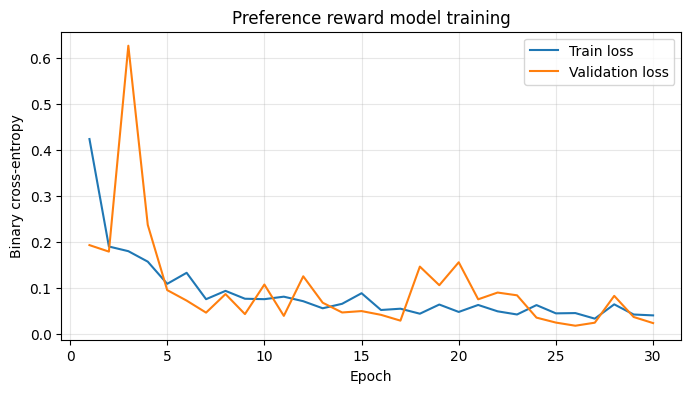

In [188]:

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy')
plt.title('Preference reward model training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

[PosixPath('../custom_datasets/policy_params.npz'), PosixPath('../custom_datasets/policy_params_0.npz'), PosixPath('../custom_datasets/policy_params_10000128.npz'), PosixPath('../custom_datasets/policy_params_13333504.npz'), PosixPath('../custom_datasets/policy_params_16666880.npz'), PosixPath('../custom_datasets/policy_params_20000256.npz'), PosixPath('../custom_datasets/policy_params_23333632.npz'), PosixPath('../custom_datasets/policy_params_26667008.npz'), PosixPath('../custom_datasets/policy_params_30000384.npz'), PosixPath('../custom_datasets/policy_params_3333376.npz'), PosixPath('../custom_datasets/policy_params_33333760.npz'), PosixPath('../custom_datasets/policy_params_36667136.npz'), PosixPath('../custom_datasets/policy_params_40000512.npz'), PosixPath('../custom_datasets/policy_params_43333888.npz'), PosixPath('../custom_datasets/policy_params_46667264.npz'), PosixPath('../custom_datasets/policy_params_50000640.npz'), PosixPath('../custom_datasets/policy_params_6666752.npz'

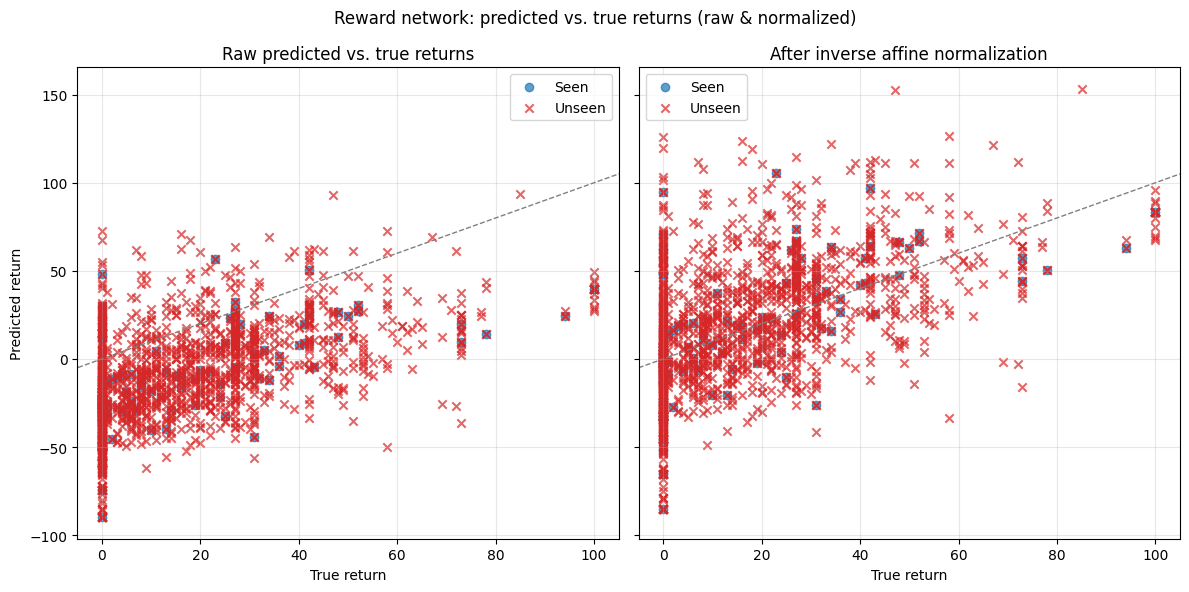

In [ ]:

import torch
import matplotlib.pyplot as plt

# Compare predicted vs. true returns on seen and unseen trajectories,
# then normalize predicted rewards via the inverse affine transform.

def evaluate_trajectory(traj):
    obs = torch.from_numpy(np.array(traj["observations"]).astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = pred_frag_return(obs).item()
    true = float(traj["reward"].sum())
    return true, pred

seen_stats = []

for d in dataset:
    seen_stats.append(evaluate_trajectory(d))
# Generate a small batch of trajectories from policies not used for training pairs
import pathlib
dataset_paths = sorted(pathlib.Path("../custom_datasets").glob("*.npz"))
print(dataset_paths)
dataset2 = CustomDataset.from_resource_path('custom_datasets/policy_params_40000512.npz', env_name="space_invaders") 
unseen_stats = []
for p in dataset_paths:
    c = CustomDataset.from_resource_path(f'custom_datasets/{p.name}', env_name='space_invaders')
    for d in c:
        unseen_stats.append(evaluate_trajectory(d))
    
true_seen = np.array([s[0] for s in seen_stats], dtype=np.float32)
pred_seen = np.array([s[1] for s in seen_stats], dtype=np.float32)
if len(true_seen) >= 2:
    slope, intercept = np.polyfit(true_seen, pred_seen, 1)
else:
    slope, intercept = 1.0, 0.0
if abs(slope) < 1e-8:
    slope = 1.0  # fallback to avoid division by zero

def normalize(stats):
    return [(true, (pred - intercept) / slope) for true, pred in stats]

normalized_seen = normalize(seen_stats)
normalized_unseen = normalize(unseen_stats)

print(f"Affine alignment: pred ≈ {slope:.3f} * true + {intercept:.3f}; applying inverse transform.")

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
for subset, stats, color in [("Seen", seen_stats, 'tab:blue'),
                             ("Unseen", unseen_stats, 'tab:red')]:
    if stats:
        ax[0].scatter(*zip(*stats), label=subset, alpha=0.7, marker='o' if subset == "Seen" else 'x', color=color)
ax[0].plot(ax[0].get_xlim(), ax[0].get_xlim(), '--', color='gray', linewidth=1)
ax[0].set_title('Raw predicted vs. true returns')
ax[0].set_xlabel('True return')
ax[0].set_ylabel('Predicted return')
ax[0].grid(True, alpha=0.3)
ax[0].legend()

for subset, stats, color in [("Seen", normalized_seen, 'tab:blue'),
                             ("Unseen", normalized_unseen, 'tab:red')]:
    if stats:
        ax[1].scatter(*zip(*stats), label=subset, alpha=0.7, marker='o' if subset == "Seen" else 'x', color=color)
lims = ax[1].get_xlim()
ax[1].plot(lims, lims, '--', color='gray', linewidth=1)
ax[1].set_xlim(lims)
ax[1].set_title('After inverse affine normalization')
ax[1].set_xlabel('True return')
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.suptitle('Reward network: predicted vs. true returns (raw & normalized)')
plt.tight_layout()
plt.show()


In [195]:
from cs592_proj.algorithms import DQN
reward_net.eval()
env = dataset.get_env()
env.override_training_reward_fn(reward_net)

algo = DQN()
run_config = RunConfig(
    num_timesteps=5000000,
    num_evals=4,
    seed=1,
)


make_policy, params, metrics = algo.train_fn(
    run_config=run_config,
    env=env,
    progress_fn=progress_fn
)

Progress 0
Progress 333568
Progress 667136
Progress 1000704
Progress 1334272
Progress 1667840
Progress 2001408
Progress 2334976
Progress 2668544
Progress 3002112
Progress 3335680
Progress 3669248
Progress 4002816
Progress 4336384
Progress 4669952
Progress 5003520


(Array(1., dtype=float32), Array(71., dtype=float32))

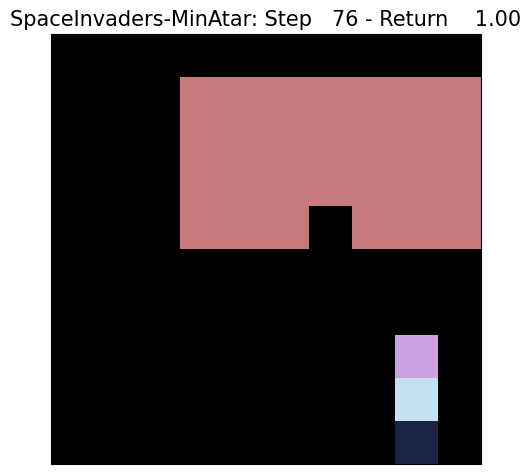

In [196]:

env = dataset.env
policy = make_policy(params, deterministic=True)

from datetime import datetime
current_datetime = datetime.now().strftime("%Y-%m-%d_%H:%M:%S.gif")

out_path =  f"./test_gifs/{current_datetime}"
visualize(env, policy, out_path)


In [234]:

from cs592_proj.algorithms import DQN
reward_net.eval()
env = dataset.get_env()

algo = DQN()
run_config = RunConfig(
    num_timesteps=5000000,
    num_evals=4,
    seed=1,
)


make_policy, params, metrics = algo.train_fn(
    run_config=run_config,
    env=env,
    progress_fn=progress_fn
)

Progress 0
Progress 333568
Progress 667136
Progress 1000704
Progress 1334272
Progress 1667840
Progress 2001408
Progress 2334976
Progress 2668544
Progress 3002112
Progress 3335680
Progress 3669248
Progress 4002816
Progress 4336384
Progress 4669952
Progress 5003520


In [26]:
policy = make_policy(params)
trajs = env.rollout(policy, 5, 1000, 5)



In [27]:
rewards = trajs["reward"]
for tr in rewards:
    print(sum(tr))

27.0
22.0
27.0
24.0
24.0


In [ ]:
trajs["reward"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)